* Whitaker Behrens
* BrainStation Data Science
* Capstone

# Pneumonia Image Classification with Neural Networks

In [99]:
# import libraries - this will take a couple seconds

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import cv2
import random

# ignore warnings !!!UNCOMMENT ONLY WHEN FINISHED!!!
# import warnings
# warnings.filterwarnings('ignore')

# import sklearn libraries

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder

# import SMOTE library

from imblearn.over_sampling import SMOTE

# import tensorflow libraries

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

# set random states for reproducability

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Importing Images

In [3]:
# import images with labels - this will take roughly 15 seconds

data_dir = 'data'
categories = ['negative', 'positive']

img_size=245

labeled_data = []

def create_labeled_data():
    
    for category in categories:
    
        path = os.path.join(data_dir, category)
        class_num = categories.index(category)

        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (img_size, img_size))
                labeled_data.append([new_array, class_num])
            except Exception:
                pass
            
create_labeled_data()

In [4]:
# check imported images

print(len(labeled_data))

5856


In [5]:
# shuffle the images

random.shuffle(labeled_data)

In [6]:
# check labels

for image in labeled_data[:10]:
    print(image[1])

0
0
1
1
1
1
1
1
1
1


In [7]:
# create X and y variables

X = []
y = []

for image, label in labeled_data:
    X.append(image)
    y.append(label)

# convert to array
    
X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

In [81]:
# check class distribution

print(np.unique(y, return_counts=True))

(array([0, 1]), array([1583, 4273]))


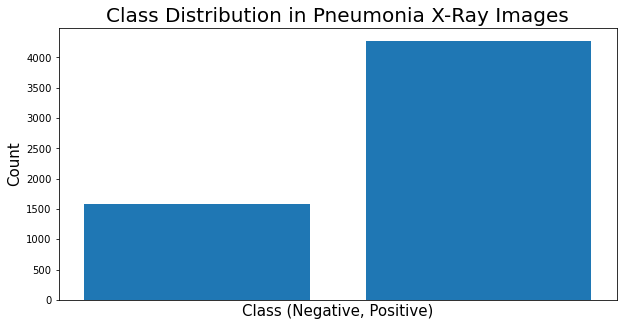

In [94]:
# visualize class distribution

plt.figure(figsize=(10,5))
plt.bar(np.unique(y, return_counts=True)[0], np.unique(y, return_counts=True)[1])
plt.title('Class Distribution in Pneumonia X-Ray Images', size=20)
plt.xlabel('Class (Negative, Positive)', size=15)
plt.ylabel('Count', size=15)
plt.xticks([])
plt.show()

In [8]:
# split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [9]:
# check shapes of split sets

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4392, 245, 245, 1) (4392,)
(1464, 245, 245, 1) (1464,)


In [10]:
# scale

X_train = X_train/255
X_test = X_test/255

In [11]:
# check pixel range

print(f'X range: {X_train.min()}-{X_train.max()}')

X range: 0.0-1.0


# Initial Modeling

In [12]:
# instantiate model

basic_model = Sequential()

# add layers with convolution, pooling, and dropout

basic_model.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape = (245, 245, 1)))
basic_model.add(MaxPooling2D(pool_size=(2, 2)))
basic_model.add(Dropout(0.25))

basic_model.add(Conv2D(64, (3, 3), activation='relu'))
basic_model.add(MaxPooling2D(pool_size=(2, 2)))
basic_model.add(Dropout(0.25))

# add flatten layer

basic_model.add(Flatten())

# add dense layers

basic_model.add(Dense(128, activation='relu'))
basic_model.add(Dense(64, activation='relu'))
basic_model.add(Dense(1, activation='sigmoid'))

# check summary

basic_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 243, 243, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 121, 121, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 121, 121, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 119, 119, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 59, 59, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 59, 59, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 222784)            0

2022-03-30 11:49:13.838288: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# compile

basic_model.compile(loss = 'binary_crossentropy',
                    optimizer = 'Adam',
                    metrics = ['accuracy'])

In [14]:
# train with 0.33 validation_split - this will take 10-15 minutes

basic_model.fit(X_train, y_train,
                batch_size = 100,
                epochs = 10,
                verbose = 1,
                validation_split = 0.33)

2022-03-30 11:49:31.327131: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/10
30/30 [==============================] - 110s 4s/step - loss: 2.1607 - accuracy: 0.6275 - val_loss: 0.5789 - val_accuracy: 0.7386
Epoch 2/10
30/30 [==============================] - 109s 4s/step - loss: 0.5164 - accuracy: 0.7427 - val_loss: 0.2830 - val_accuracy: 0.8924
Epoch 3/10
30/30 [==============================] - 108s 4s/step - loss: 0.2671 - accuracy: 0.8771 - val_loss: 0.1953 - val_accuracy: 0.9276
Epoch 4/10
30/30 [==============================] - 110s 4s/step - loss: 0.1885 - accuracy: 0.9260 - val_loss: 0.1675 - val_accuracy: 0.9386
Epoch 5/10
30/30 [==============================] - 108s 4s/step - loss: 0.1398 - accuracy: 0.9447 - val_loss: 0.1517 - val_accuracy: 0.9421
Epoch 6/10
30/30 [==============================] - 108s 4s/step - loss: 0.1239 - accuracy: 0.9542 - val_loss: 0.1642 - val_accuracy: 0.9414
Epoch 7/10
30/30 [==============================] - 109s 4s/step - loss: 0.1268 - accuracy: 0.9556 - val_loss: 0.1349 - val_accuracy: 0.9503
Epoch 8/10
30

# Evaluating First Model

In [16]:
# test score - this will take a few seconds

score = basic_model.evaluate(X_test, y_test, verbose=0)

print(f'Test loss: {score[0]}')
print(f'Test accuracy: {score[1]}')

Test loss: 0.14625588059425354
Test accuracy: 0.943306028842926


In [17]:
# get predictions - this will take a few seconds

y_pred = basic_model.predict_classes(X_test)

/opt/anaconda3/envs/deeplearning/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [18]:
# viusualize confusion matrix

cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(
    cm,
    columns=['Predicted Negative', 'Predicted Positive'],
    index=['True Negative', 'True Positive']
)

cm_df

,Predicted Negative,Predicted Positive
True Negative,379,34
True Positive,49,1002


In [19]:
# calculate precision and recall

tp = cm[1,1]
tn = cm[0,0]
fp = cm[0,1]
fn = cm[1,0]

prec = round(tp/(tp+fp), 4)*100
rec = round(tp/(tp+fn), 4)*100

print(f'Model precision: {prec}')
print(f'Model recall: {rec}')

Model precision: 96.72
Model recall: 95.34


# Second Model with Weighted Classes

In [20]:
# calculate balanced class weights

class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(y_train),
                                                  y_train)

# check

class_weights

/opt/anaconda3/envs/deeplearning/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 1 1 ... 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


array([1.87692308, 0.68156425])

In [21]:
# convert class_weights to dict

class_weights = dict(enumerate(class_weights))

# check

class_weights

{0: 1.876923076923077, 1: 0.6815642458100558}

In [28]:
# instantiate new model

weighted_model = Sequential()

# add layers

weighted_model.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape = (245, 245, 1)))
weighted_model.add(MaxPooling2D(pool_size=(2, 2)))
weighted_model.add(Dropout(0.25))

weighted_model.add(Conv2D(64, (3, 3), activation='relu'))
weighted_model.add(MaxPooling2D(pool_size=(2, 2)))
weighted_model.add(Dropout(0.25))

# flatten

weighted_model.add(Flatten())

# add dense layers

weighted_model.add(Dense(128, activation='relu'))
weighted_model.add(Dense(64, activation='relu'))
weighted_model.add(Dense(1, activation='sigmoid'))

weighted_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 243, 243, 32)      320       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 121, 121, 32)      0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 121, 121, 32)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 119, 119, 64)      18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 59, 59, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 59, 59, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 222784)           

In [29]:
# compile

weighted_model.compile(loss = 'binary_crossentropy',
                    optimizer = 'Adam',
                    metrics = ['accuracy'])

In [30]:
# train - this will take 10-15 minutes

weighted_model.fit(X_train, y_train,
                batch_size = 100,
                epochs = 10,
                verbose = 1,
                validation_split = 0.33,
                class_weight=class_weights)

Epoch 1/10
30/30 [==============================] - 119s 4s/step - loss: 2.3106 - accuracy: 0.5053 - val_loss: 0.6847 - val_accuracy: 0.6814
Epoch 2/10
30/30 [==============================] - 120s 4s/step - loss: 0.5866 - accuracy: 0.7941 - val_loss: 0.2153 - val_accuracy: 0.9124
Epoch 3/10
30/30 [==============================] - 122s 4s/step - loss: 0.2774 - accuracy: 0.8773 - val_loss: 0.2406 - val_accuracy: 0.9090
Epoch 4/10
30/30 [==============================] - 115s 4s/step - loss: 0.1865 - accuracy: 0.9251 - val_loss: 0.1623 - val_accuracy: 0.9400
Epoch 5/10
30/30 [==============================] - 116s 4s/step - loss: 0.1397 - accuracy: 0.9472 - val_loss: 0.1756 - val_accuracy: 0.9359
Epoch 6/10
30/30 [==============================] - 112s 4s/step - loss: 0.1163 - accuracy: 0.9597 - val_loss: 0.1480 - val_accuracy: 0.9434
Epoch 7/10
30/30 [==============================] - 108s 4s/step - loss: 0.1235 - accuracy: 0.9515 - val_loss: 0.1288 - val_accuracy: 0.9490
Epoch 8/10
30

In [31]:
# evaluate - this will take a few seconds

weighted_score = weighted_model.evaluate(X_test, y_test, verbose=0)

print(f'Basic model test accuracy: {score[1]}')
print(f'Weighted model test accuracy: {weighted_score[1]}')

Basic model test accuracy: 0.943306028842926
Weighted model test accuracy: 0.9446721076965332


In [33]:
# predict and visualize confusion matrix - this will take a few seconds

y_pred_weight = weighted_model.predict_classes(X_test)

cm_weight = confusion_matrix(y_test, y_pred_weight)

cm_weight_df = pd.DataFrame(
    cm_weight,
    columns=['Predicted Negative', 'Predicted Positive'],
    index=['True Negative', 'True Positive']
)

cm_weight_df

/opt/anaconda3/envs/deeplearning/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


,Predicted Negative,Predicted Positive
True Negative,387,26
True Positive,55,996


In [34]:
# precision and recall

tp_w = cm_weight[1,1]
tn_w = cm_weight[0,0]
fp_w = cm_weight[0,1]
fn_w = cm_weight[1,0]

prec_weight = round(tp_w/(tp_w+fp_w), 4)*100
rec_weight = round(tp_w/(tp_w+fn_w), 4)*100

print(f'Original model precision, recall: {prec, rec}')
print(f'Weighted model precision, recall: {prec_weight, rec_weight}')

Original model precision, recall: (96.72, 95.34)
Weighted model precision, recall: (97.46000000000001, 94.77)


# Third Model with SMOTE

In [35]:
# instantiate SMOTE sampler

sm = SMOTE(random_state=42)

In [36]:
# reshape train array for SMOTE

X_train_reshaped = X_train.reshape(4392, 60025)

In [37]:
# fit and resample - this will take a few seconds

X_smote, y_smote = sm.fit_resample(X_train_reshaped, y_train)

In [38]:
# reshape smote array for model

X_smote = X_smote.reshape(X_smote.shape[0], 245, 245, 1)

# check

print(X_smote.shape)
print(y_smote.shape)

(6444, 245, 245, 1)
(6444,)


(array([0, 1]), array([3222, 3222]))


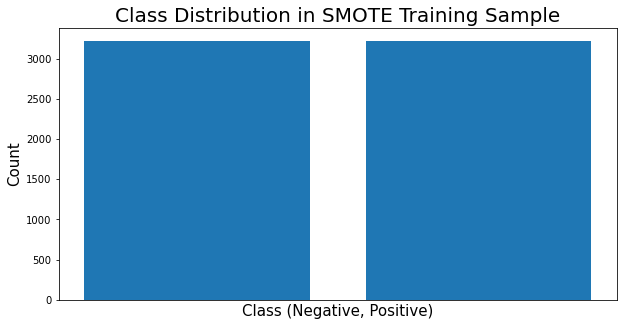

In [96]:
# recheck class distribution

print(np.unique(y_smote, return_counts=True))

# visualize

plt.figure(figsize=(10,5))
plt.bar(np.unique(y_smote, return_counts=True)[0], np.unique(y_smote, return_counts=True)[1])
plt.title('Class Distribution in SMOTE Training Sample', size=20)
plt.xlabel('Class (Negative, Positive)', size=15)
plt.ylabel('Count', size=15)
plt.xticks([])
plt.show()

In [39]:
# instantiate new model

smote_model = Sequential()

# add layers

smote_model.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape = (245, 245, 1)))
smote_model.add(MaxPooling2D(pool_size=(2, 2)))
smote_model.add(Dropout(0.25))

smote_model.add(Conv2D(64, (3, 3), activation='relu'))
smote_model.add(MaxPooling2D(pool_size=(2, 2)))
smote_model.add(Dropout(0.25))

# flatten

smote_model.add(Flatten())

# add dense layers

smote_model.add(Dense(128, activation='relu'))
smote_model.add(Dense(64, activation='relu'))
smote_model.add(Dense(1, activation='sigmoid'))

# summary

smote_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 243, 243, 32)      320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 121, 121, 32)      0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 121, 121, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 119, 119, 64)      18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 59, 59, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 59, 59, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 222784)           

In [40]:
# compile

smote_model.compile(loss = 'binary_crossentropy',
                    optimizer = 'Adam',
                    metrics = ['accuracy'])

In [41]:
# train - this will take about 30 minutes

smote_model.fit(X_smote, y_smote,
                batch_size = 100,
                epochs = 10,
                verbose = 1,
                validation_split = 0.33)

Epoch 1/10
44/44 [==============================] - 174s 4s/step - loss: 1.8316 - accuracy: 0.6263 - val_loss: 0.6419 - val_accuracy: 0.8590
Epoch 2/10
44/44 [==============================] - 176s 4s/step - loss: 0.3237 - accuracy: 0.8655 - val_loss: 0.3787 - val_accuracy: 0.8599
Epoch 3/10
44/44 [==============================] - 175s 4s/step - loss: 0.1512 - accuracy: 0.9390 - val_loss: 0.2908 - val_accuracy: 0.8900
Epoch 4/10
44/44 [==============================] - 174s 4s/step - loss: 0.1276 - accuracy: 0.9489 - val_loss: 0.2972 - val_accuracy: 0.8905
Epoch 5/10
44/44 [==============================] - 175s 4s/step - loss: 0.1245 - accuracy: 0.9513 - val_loss: 0.2777 - val_accuracy: 0.8966
Epoch 6/10
44/44 [==============================] - 176s 4s/step - loss: 0.0894 - accuracy: 0.9637 - val_loss: 0.3423 - val_accuracy: 0.8641
Epoch 7/10
44/44 [==============================] - 169s 4s/step - loss: 0.0925 - accuracy: 0.9661 - val_loss: 0.2508 - val_accuracy: 0.9022
Epoch 8/10
44

In [42]:
# evaluate - this will take a few seconds

smote_score = smote_model.evaluate(X_test, y_test, verbose=0)

print(f'Basic model test accuracy: {score[1]}')
print(f'SMOTE model test accuracy: {smote_score[1]}')

Basic model test accuracy: 0.943306028842926
SMOTE model test accuracy: 0.9228141903877258


In [43]:
# confusion matrix - this will take a few seconds

y_pred_smote = smote_model.predict_classes(X_test)

cm_smote = confusion_matrix(y_test, y_pred_smote)

cm_smote_df = pd.DataFrame(
    cm_smote,
    columns=['Predicted Negative', 'Predicted Positive'],
    index=['True Negative', 'True Positive']
)

cm_smote_df

/opt/anaconda3/envs/deeplearning/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


,Predicted Negative,Predicted Positive
True Negative,396,17
True Positive,96,955


In [44]:
# precision and recall

tp_s = cm_smote[1,1]
tn_s = cm_smote[0,0]
fp_s = cm_smote[0,1]
fn_s = cm_smote[1,0]

prec_smote = round(tp_s/(tp_s+fp_s), 4)*100
rec_smote = round(tp_s/(tp_s+fn_s), 4)*100

print(f'Original model precision, recall: {prec, rec}')
print(f'Weighted model precision, recall: {prec_weight, rec_weight}')
print(f'SMOTE model precision, recall: {prec_smote, rec_smote}')

Original model precision, recall: (96.72, 95.34)
Weighted model precision, recall: (97.46000000000001, 94.77)
SMOTE model precision, recall: (98.25, 90.86999999999999)


# Splitting Positive Class into Bacterial and Viral Classes

In [45]:
# define import functions

def load_negative(neg_path):
    
    neg_files = np.array(os.listdir(neg_path))
    neg_labels = np.array(['negative']*len(neg_files))
    
    neg_images = []
    
    for image in neg_files:
        try:
            image = cv2.imread(neg_path + image)
            image = cv2.resize(image, dsize=(img_size, img_size))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            neg_images.append(image)
        except Exception:
            pass
        
    neg_images = np.array(neg_images)
    
    return neg_images, neg_labels

def load_positive(pos_path):
    
    pos_files = np.array(os.listdir(pos_path))
    pos_labels = np.array([pos_file.split('_')[1] for pos_file in pos_files])
    
    pos_images = []
    
    for image in pos_files:
        try:
            image = cv2.imread(pos_path + image)
            image = cv2.resize(image, dsize=(img_size, img_size))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            pos_images.append(image)
        except Exception:
            pass
        
    pos_images = np.array(pos_images)
    
    return pos_images, pos_labels

In [46]:
# import images and labels this will take roughly 20 seconds

neg_images, neg_labels = load_negative('data/negative/')
pos_images, pos_labels = load_positive('data/positive/')

In [47]:
# create X and y variables

X2 = np.append(neg_images, pos_images, axis=0)
y2 = np.append(neg_labels, pos_labels)

# check

print(X2.shape, y2.shape)
print(np.unique(y2, return_counts=True))

(5856, 245, 245) (5856,)
(array(['bacteria', 'negative', 'virus'], dtype='<U8'), array([2780, 1583, 1493]))


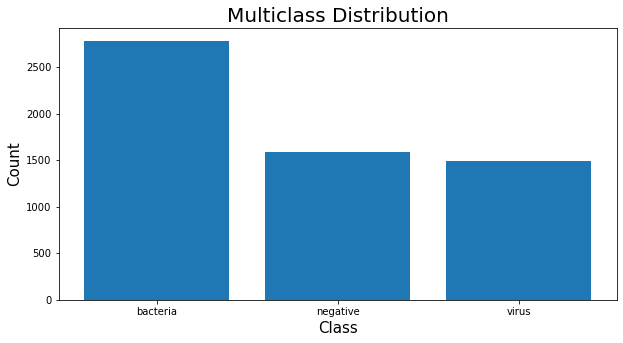

In [98]:
# visualize multiclass distribution

plt.figure(figsize=(10,5))
plt.bar(np.unique(y2, return_counts=True)[0], np.unique(y2, return_counts=True)[1])
plt.title('Multiclass Distribution', size=20)
plt.xlabel('Class', size=15)
plt.ylabel('Count', size=15)
plt.show()

In [48]:
# reshape X for model

X2 = X2.reshape(X2.shape[0], 245, 245, 1)

# check

print(X2.shape)

(5856, 245, 245, 1)


In [49]:
# split data

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25, random_state=42)

# check

print(X2_train.shape, y2_train.shape)
print(X2_test.shape, y2_test.shape)

(4392, 245, 245, 1) (4392,)
(1464, 245, 245, 1) (1464,)


In [50]:
# scale

X2_train = X2_train/255
X2_test = X2_test/255

# check

print(f'X range: {X2_train.min()}-{X2_train.max()}')

X range: 0.0-1.0


In [51]:
# reshape y2_train and y2_test for encoder

y2_train = y2_train[:, np.newaxis]
y2_test = y2_test[:, np.newaxis]

In [52]:
# instantiate OHE

ohe = OneHotEncoder(sparse=False)

# encode labels for model

y2_train = ohe.fit_transform(y2_train)
y2_test = ohe.transform(y2_test)

In [53]:
# check

print(y2_train.shape, y2_test.shape)

(4392, 3) (1464, 3)


# Multiple Positive Classes Modeling

In [57]:
# instantiate new model

mul_pos_model = Sequential()

# add layers

mul_pos_model.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape = (245, 245, 1)))
mul_pos_model.add(MaxPooling2D(pool_size=(2, 2)))
mul_pos_model.add(Dropout(0.25))

mul_pos_model.add(Conv2D(64, (3, 3), activation='relu'))
mul_pos_model.add(MaxPooling2D(pool_size=(2, 2)))
mul_pos_model.add(Dropout(0.25))

# flatten

mul_pos_model.add(Flatten())

# add dense layers

mul_pos_model.add(Dense(128, activation='relu'))
mul_pos_model.add(Dense(64, activation='relu'))
mul_pos_model.add(Dense(3, activation='softmax'))

# summary

mul_pos_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 243, 243, 32)      320       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 121, 121, 32)      0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 121, 121, 32)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 119, 119, 64)      18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 59, 59, 64)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 59, 59, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 222784)           

In [58]:
# compile

mul_pos_model.compile(loss = 'categorical_crossentropy',
                    optimizer = 'Adam',
                    metrics = ['accuracy'])

In [59]:
# train - this will take 15-20 minutes

mul_pos_model.fit(X2_train, y2_train,
                batch_size = 100,
                epochs = 10,
                verbose = 1,
                validation_split = 0.33)

Epoch 1/10
30/30 [==============================] - 119s 4s/step - loss: 3.5359 - accuracy: 0.3726 - val_loss: 1.0587 - val_accuracy: 0.4993
Epoch 2/10
30/30 [==============================] - 121s 4s/step - loss: 0.9720 - accuracy: 0.5436 - val_loss: 0.7094 - val_accuracy: 0.7090
Epoch 3/10
30/30 [==============================] - 110s 4s/step - loss: 0.6808 - accuracy: 0.7148 - val_loss: 0.5782 - val_accuracy: 0.7559
Epoch 4/10
30/30 [==============================] - 109s 4s/step - loss: 0.5411 - accuracy: 0.7751 - val_loss: 0.5483 - val_accuracy: 0.7683
Epoch 5/10
30/30 [==============================] - 109s 4s/step - loss: 0.4969 - accuracy: 0.7811 - val_loss: 0.5595 - val_accuracy: 0.7593
Epoch 6/10
30/30 [==============================] - 109s 4s/step - loss: 0.4924 - accuracy: 0.7867 - val_loss: 0.5280 - val_accuracy: 0.7814
Epoch 7/10
30/30 [==============================] - 112s 4s/step - loss: 0.4430 - accuracy: 0.8023 - val_loss: 0.5354 - val_accuracy: 0.7772
Epoch 8/10
30

# Evaluating Multiclass Model

In [60]:
# accuracy score - this will take a few seconds

mul_pos_score = mul_pos_model.evaluate(X2_test, y2_test, verbose=0)

print(f'Multiclass test loss: {mul_pos_score[0]}')
print(f'Multiclass test accuracy: {mul_pos_score[1]}')

Multiclass test loss: 0.5468177795410156
Multiclass test accuracy: 0.7704917788505554


In [61]:
# predict - this will take a few seconds

y2_pred = mul_pos_model.predict(X2_test)

# revert to class labels

y2_pred = ohe.inverse_transform(y2_pred)

y2_test_labels = ohe.inverse_transform(y2_test)

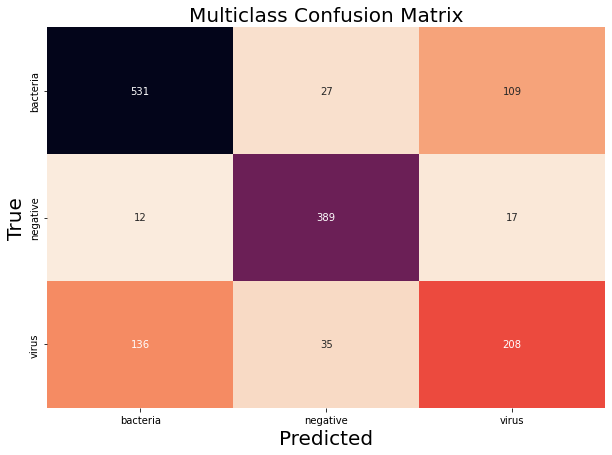

In [62]:
# visualize confusion matrix

mul_pos_cm = confusion_matrix(y2_test_labels, y2_pred)

plt.figure(figsize=(10,7))
sns.heatmap(mul_pos_cm, xticklabels=['bacteria', 'negative', 'virus'], yticklabels=['bacteria', 'negative', 'virus'], fmt='d', annot=True, cbar=False, cmap='rocket_r')
plt.title('Multiclass Confusion Matrix', size=20)
plt.xlabel('Predicted', size=20)
plt.ylabel('True', size=20)
plt.show()

In [63]:
# calculate metrics

print(classification_report(y2_test_labels, y2_pred, digits=4))

              precision    recall  f1-score   support

    bacteria     0.7820    0.7961    0.7890       667
    negative     0.8625    0.9306    0.8953       418
       virus     0.6228    0.5488    0.5835       379

    accuracy                         0.7705      1464
   macro avg     0.7558    0.7585    0.7559      1464
weighted avg     0.7638    0.7705    0.7661      1464



In [64]:
# comparing accuracy

print(f'Basic model test accuracy: {score[1]}')
print(f'Weighted model test accuracy: {weighted_score[1]}')
print(f'SMOTE model test accuracy: {smote_score[1]}')
print(f'Multiclass model test accuracy: {mul_pos_score[1]}')

Basic model test accuracy: 0.943306028842926
Weighted model test accuracy: 0.9446721076965332
SMOTE model test accuracy: 0.9228141903877258
Multiclass model test accuracy: 0.7704917788505554


# Modeling Only Positive Classes

In [100]:
# create X and y variables

X_pos = pos_images
y_pos = pos_labels

# check shape

print(X_pos.shape, y_pos.shape)
print(np.unique(y_pos, return_counts=True))

(4273, 245, 245) (4273,)
(array(['bacteria', 'virus'], dtype='<U8'), array([2780, 1493]))


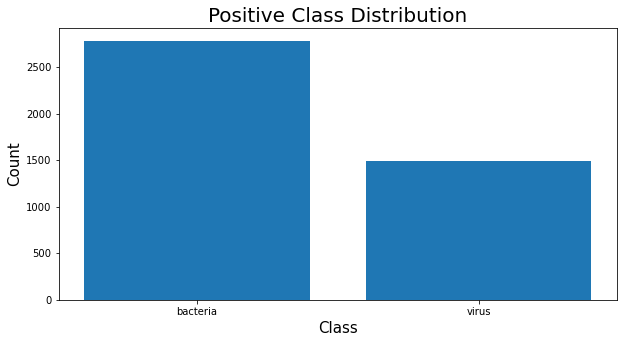

In [101]:
# visualize class distribution

plt.figure(figsize=(10,5))
plt.bar(np.unique(y_pos, return_counts=True)[0], np.unique(y_pos, return_counts=True)[1])
plt.title('Positive Class Distribution', size=20)
plt.xlabel('Class', size=15)
plt.ylabel('Count', size=15)
plt.show()

In [102]:
# reshape X for model

X_pos = X_pos.reshape(X_pos.shape[0], 245, 245, 1)

# check

print(X_pos.shape)

(4273, 245, 245, 1)


In [103]:
# split data

X_pos_train, X_pos_test, y_pos_train, y_pos_test = train_test_split(X_pos, y_pos, test_size=0.25, random_state=42)

# check

print(X_pos_train.shape, y_pos_train.shape)
print(X_pos_test.shape, y_pos_test.shape)

(3204, 245, 245, 1) (3204,)
(1069, 245, 245, 1) (1069,)


In [104]:
# scale

X_pos_train = X_pos_train/255
X_pos_test = X_pos_test/255

# check

print(f'X range: {X_pos_train.min()}-{X_pos_train.max()}')

X range: 0.0-1.0


In [105]:
# reshape y to encode

y_pos_train = y_pos_train[:, np.newaxis]
y_pos_test = y_pos_test[:, np.newaxis]

In [106]:
# instantiate OHE

ohe = OneHotEncoder(sparse=False)

# encode labels for model

y_pos_train = ohe.fit_transform(y_pos_train)
y_pos_test = ohe.transform(y_pos_test)

# check

print(y_pos_train.shape, y_pos_test.shape)

(3204, 2) (1069, 2)


In [111]:
# instantiate model

positive_model = Sequential()

# add layers

positive_model.add(Conv2D(32, kernel_size=(3, 3), activation = 'relu', input_shape = (245, 245, 1)))
positive_model.add(MaxPooling2D(pool_size=(2, 2)))
positive_model.add(Dropout(0.25))

positive_model.add(Conv2D(64, (3, 3), activation='relu'))
positive_model.add(MaxPooling2D(pool_size=(2, 2)))
positive_model.add(Dropout(0.25))

# flatten

positive_model.add(Flatten())

# add dense layers

positive_model.add(Dense(128, activation='relu'))
positive_model.add(Dense(64, activation='relu'))
positive_model.add(Dense(2, activation='softmax'))

# summary

positive_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 243, 243, 32)      320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 121, 121, 32)      0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 121, 121, 32)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 119, 119, 64)      18496     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 59, 59, 64)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 59, 59, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 222784)           

In [112]:
# compile

positive_model.compile(loss = 'binary_crossentropy',
                    optimizer = 'Adam',
                    metrics = ['accuracy'])

In [113]:
# train - this will take 15-20 minutes

positive_model.fit(X_pos_train, y_pos_train,
                batch_size = 100,
                epochs = 10,
                verbose = 1,
                validation_split = 0.33)

Epoch 1/10
22/22 [==============================] - 87s 4s/step - loss: 1.1749 - accuracy: 0.5745 - val_loss: 0.6895 - val_accuracy: 0.6257
Epoch 2/10
22/22 [==============================] - 86s 4s/step - loss: 0.6603 - accuracy: 0.6560 - val_loss: 0.6391 - val_accuracy: 0.6437
Epoch 3/10
22/22 [==============================] - 86s 4s/step - loss: 0.5936 - accuracy: 0.6823 - val_loss: 0.5194 - val_accuracy: 0.7665
Epoch 4/10
22/22 [==============================] - 87s 4s/step - loss: 0.5358 - accuracy: 0.7448 - val_loss: 0.5048 - val_accuracy: 0.7703
Epoch 5/10
22/22 [==============================] - 86s 4s/step - loss: 0.4737 - accuracy: 0.7746 - val_loss: 0.5535 - val_accuracy: 0.7609
Epoch 6/10
22/22 [==============================] - 85s 4s/step - loss: 0.5011 - accuracy: 0.7655 - val_loss: 0.5095 - val_accuracy: 0.7788
Epoch 7/10
22/22 [==============================] - 86s 4s/step - loss: 0.4492 - accuracy: 0.7885 - val_loss: 0.5236 - val_accuracy: 0.7647
Epoch 8/10
22/22 [==

In [120]:
# score - this will take a few seconds

pos_score = positive_model.evaluate(X_pos_test, y_pos_test, verbose=0)

print(f'Multiclass test loss: {pos_score[0]}')
print(f'Multiclass test accuracy: {pos_score[1]}')

Multiclass test loss: 0.4837481379508972
Multiclass test accuracy: 0.7717493176460266


In [118]:
# predict - this will take a few seconds

y_pos_pred = positive_model.predict(X_pos_test)

# revert to class labels

y_pos_pred = ohe.inverse_transform(y_pos_pred)

y_pos_test_labels = ohe.inverse_transform(y_pos_test)

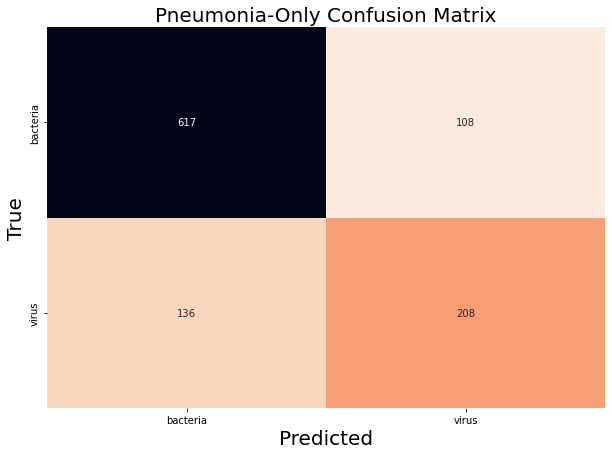

In [119]:
# visualize confusion matrix

positive_cm = confusion_matrix(y_pos_test_labels, y_pos_pred)

plt.figure(figsize=(10,7))
sns.heatmap(positive_cm, xticklabels=['bacteria', 'virus'], yticklabels=['bacteria', 'virus'], fmt='d', annot=True, cbar=False, cmap='rocket_r')
plt.title('Pneumonia-Only Confusion Matrix', size=20)
plt.xlabel('Predicted', size=20)
plt.ylabel('True', size=20)
plt.show()

In [121]:
# compare models

print(f'Basic model test accuracy: {score[1]}')
print(f'Weighted model test accuracy: {weighted_score[1]}')
print(f'SMOTE model test accuracy: {smote_score[1]}')
print(f'Multiclass model test accuracy: {mul_pos_score[1]}')
print(f'Positive-Only model test accuracy: {pos_score[1]}')

Basic model test accuracy: 0.943306028842926
Weighted model test accuracy: 0.9446721076965332
SMOTE model test accuracy: 0.9228141903877258
Multiclass model test accuracy: 0.7704917788505554
Positive-Only model test accuracy: 0.7717493176460266
